Here I will have some examples showing how to use **sampyl**. This is for version 0.1. Let's import it and get started. **sampyl** uses [autograd](https://github.com/HIPS/autograd) for calculating gradients, so all `logp` functions must be built using the numpy provided by autograd. Be sure to [read up](https://github.com/HIPS/autograd/blob/master/docs/tutorial.md) on the restrictions when using autograd's numpy.

In [4]:
%matplotlib inline

import autograd.numpy as np
import matplotlib.pyplot as plt
import sampyl as smp

Every sampler provided by **sampyl** works the same way. Define $ \log (P(\theta)) $ as a function, then pass it to the sampler class. The class returns a sampler object, which you can then use to sample from $ P(x) $. Starting out simple, let's sample from a normal distribution.

In [5]:
mu, sig = 3, 2
def logp(x):
    return -0.5*np.log(2*np.pi) - 0.5*np.log(sig**2) - np.sum((x - mu)**2)/(2*sig**2)

First we'll use a Metropolis-Hastings sampler.

In [6]:
metro = smp.Metropolis(logp)
trace = metro.sample(10000, burn=2000, thin=4)

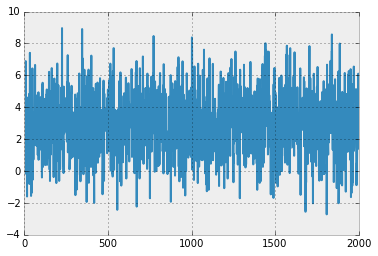

In [7]:
plt.plot(trace)

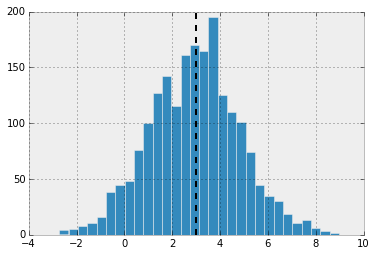

In [8]:
_ = plt.hist(trace, bins=30)
plt.vlines(mu, 0, 200, linestyles='--')

There is also a No-U-Turn Sampler (NUTS), which avoids the random-walk nature of Metropolis samplers.

In [9]:
nuts = smp.NUTS(logp)
trace = nuts.sample(1000)

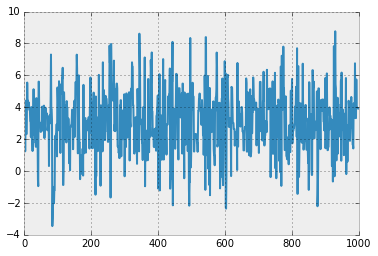

In [10]:
plt.plot(trace)

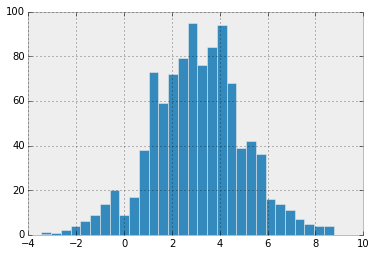

In [11]:
_ = plt.hist(trace, bins=30)

Let's try something a little more complicated. Let's say you run a business and you put an advertisement in the paper. Then, to judge the effectiveness of the ad, you want to compare the number of incoming phone calls per hour before and after the placement of the add. Then we can build a simple model using a Poisson likelihood.


\begin{align}
P(\lambda_1, \lambda_2 \mid D) &\propto P( D \mid \lambda_1, \lambda_2)\, P(\lambda_1)\, P(\lambda_2) \\
P( D \mid \lambda_1, \lambda_2) &\sim \mathrm{Poisson}(D\mid\lambda_1)\,\mathrm{Poisson}(D\mid\lambda_2) \\
P(\lambda_1) &\sim \mathrm{Exp}(1) \\
P(\lambda_2) &\sim \mathrm{Exp}(1) 
\end{align}


In [19]:
# Fake data for the day before and after placing the ad
before = np.random.poisson(7, size=12)
after = np.random.poisson(9, size=12)
def logp(lam1, lam2):
    # Rates for Poisson must be > 0
    if lam1 <= 0 or lam2 <=0:
        return -100000.
    else:
        # logps for likelihoods
        llh1 = np.sum(before*np.log(lam1)) - before.size*lam1
        llh2 = np.sum(after*np.log(lam2)) - after.size*lam2
        
        # logps for priors
        lam1_prior = -lam1
        lam2_prior = -lam2
        return llh1 + llh2 + lam1_prior + lam2_prior

In [20]:
metro = smp.Metropolis(logp, start=(1.,1.))
trace = metro.sample(10000, burn=2000, thin=4)

Sampling returns a `Trace` object which you can use to access samples by name. Variable names are taken directly from the argument list of `logp`.

In [21]:
print(trace.var_names)

['lam1_', 'lam2_']


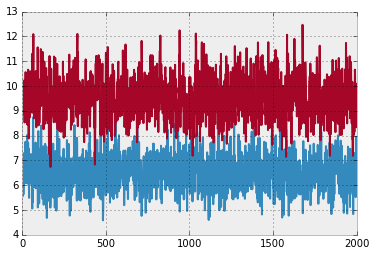

In [22]:
plt.plot(trace.lam1_)
plt.plot(trace.lam2_)

Now to see if there is a significant difference between the two days. We can find the difference $\delta =  \lambda_2 - \lambda_1$, then find the probability that $\delta > 0$.

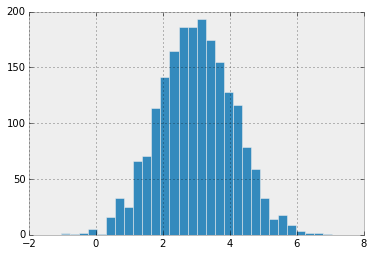

In [23]:
delta = trace.lam2_ - trace.lam1_
_ = plt.hist(delta, bins=30)

In [24]:
p = np.mean(delta > 0)
print("{} probability the rate of phone calls increased".format(p))

0.9955 probability the rate of phone calls increased


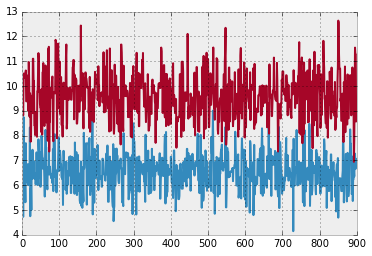

In [25]:
nuts = smp.NUTS(logp, start=(1.,1.))
trace = nuts.sample(1000, burn=100)
_ = plt.plot(trace)

NUTS works as well!

The future
----------

* Write a module that makes it easier to build logp functions from distributions
* Add various functions such as autocorrelation, HPD, etc.
* Slice sampler!
* A function to find the MAP for use as a starting state.